In [30]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time
import pandas as pd

In [2]:
file = 'spa/spa.txt'

In [35]:
inputs,targets = [],[] 
with open(file , 'r' , encoding = 'utf-8') as f:
    lines = f.read().strip().split('\n')
    for line in lines:
        tar,inp,_ = line.split('\t')
        if (len(inp.split(' '))-2)*(10-len(inp.split(' '))) > 0:
            inputs.append(inp)
            targets.append(tar)
data = pd.DataFrame(list(zip(inputs,targets)) , columns =['spanish' , 'english'] )
data=data[data['english'].apply(lambda x:  len(x.split(' ')) < 10)]
data.drop_duplicates(inplace = True ,subset="english" ,ignore_index =True)
data=data.sample(frac=1)

In [36]:
data

spanish  \
49485                ¿Te divierte vivir así?   
15928  Cualquiera de vosotros puede hacerlo.   
6482                  Mi pulso está elevado.   
62206            La reunión tuvo lugar ayer.   
7003                     Tom es un veterano.   
...                                      ...   
73556         Había harta comida en la casa.   
6513                     Nadie tiene hambre.   
27320                  No tengo un favorito.   
34782          ¿Cómo podría Tom no quererme?   
38912             Sabía que algo estaba mal.   

                                     english  
49485         Do you enjoy living like this?  
15928                  Any of you can do it.  
6482                       My pulse is fast.  
62206      The meeting took place yesterday.  
7003                       Tom is a veteran.  
...                                      ...  
73556  There was a lot of food in the house.  
6513                       Nobody is hungry.  
27320               I don't have a favorite.  
34782             How could Tom not like me?  
38912            I knew something was wrong.  

[89486 rows x 2 columns]

In [37]:
lines = ""
for i in range(len(data)):
    l = data['spanish'].iloc[i] + '\t' + data['english'].iloc[i] + '\n'
    lines = lines + l

In [38]:
lines

'¿Te divierte vivir así?\tDo you enjoy living like this?\nCualquiera de vosotros puede hacerlo.\tAny of you can do it.\nMi pulso está elevado.\tMy pulse is fast.\nLa reunión tuvo lugar ayer.\tThe meeting took place yesterday.\nTom es un veterano.\tTom is a veteran.\n«¿A él le gusta la música?» «Sí.»\t"Does he like music?" "Yes, he does."\nTe puedo dar medicina para el dolor.\tI can give you medication for the pain.\nTom no sabe qué hora es.\tTom doesn\'t know what time it is.\nLa habitación se mantuvo cálida para los huéspedes.\tThe room was kept warm for the guests.\nLa llama se extinguió.\tThe flame went out.\n¿Puedo tocar tu mandolina?\tCan I play your mandolin?\nYo tampoco consigo verle.\tI can\'t see him either.\nEso también es cierto.\tThat\'s true as well.\nEstaba al teléfono.\tI was on the phone.\nPensé que Tom entendería.\tI thought that Tom would understand.\nTom dejó de limpiar.\tTom stopped cleaning.\nDebes cumplir tus promesas.\tYou should fulfill your promises.\nÉl fue lo

In [39]:
lines.split('\n')[:3]

['¿Te divierte vivir así?\tDo you enjoy living like this?',
 'Cualquiera de vosotros puede hacerlo.\tAny of you can do it.',
 'Mi pulso está elevado.\tMy pulse is fast.']

In [40]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn'
                  )

In [41]:
def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    w = '<start> ' + w + ' <end>'
    return w

In [42]:
def create_dataset(lines, num_examples):
    lines = lines.strip().split('\n')
    word_pairs = [
                    [
                        preprocess_sentence(w) for w in line.split('\t')
                    ]
                    for line in lines[ :num_examples ]
                 ]
    return zip(*word_pairs)

In [43]:
def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
    return tensor, lang_tokenizer

In [44]:
def load_dataset(path, num_examples=None):
        inp_lang,targ_lang = create_dataset(path, num_examples)
        input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
        target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
        return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [45]:
num_examples = 40000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(lines,num_examples)
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

32000 32000 8000 8000


In [46]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 400
steps_per_epoch = len(input_tensor_train) //BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([400, 17]), TensorShape([400, 19]))

In [47]:
len(targ_lang.word_index)

8478

In [48]:
from keras import layers,Model

In [49]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                     recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [50]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
            super(Decoder, self).__init__()
            self.batch_sz = batch_sz
            self.dec_units = dec_units
            self.embedding = layers.Embedding(vocab_size, embedding_dim)
            self.gru = layers.GRU(self.dec_units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
            self.fc = tf.keras.layers.Dense(vocab_size)
            self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
            
            context_vector, attention_weights = self.attention(hidden, enc_output)
            x = self.embedding(x)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
            output, state = self.gru(x)
            output = tf.reshape(output, (-1, output.shape[2]))
            x = self.fc(output)

            return x, state, attention_weights

In [51]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        
        query_with_time_axis = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [52]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units)', sample_output.shape)
print('Encoder Hidden state shape: (batch size, units)', sample_hidden.shape) 

Encoder output shape: (batch size, sequence length, units) (400, 17, 1024)
Encoder Hidden state shape: (batch size, units) (400, 1024)


In [53]:
attention_layer = BahdanauAttention(200)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
print("Attention result shape: (batch size, units)", attention_result.shape)
print("Attention weights shape: (batch_size, sequence_length, 1)", attention_weights.shape)

Attention result shape: (batch size, units) (400, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (400, 17, 1)


In [54]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
print('Decoder output shape: (batch_size, vocab size)', sample_decoder_output.shape)

Decoder output shape: (batch_size, vocab size) (400, 8479)


In [55]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True,
                                                            reduction='none')

In [56]:
def loss_function(real, pred):
      mask = tf.math.logical_not(tf.math.equal(real, 0))
      loss_ = loss_object(real, pred)

      mask = tf.cast(mask, dtype=loss_.dtype)
      loss_ *= mask

      return tf.reduce_mean(loss_)

In [57]:
#checkpounts for saved models
checkpoint_dir = './spa_training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                  encoder=encoder,
                                  decoder=decoder)

In [58]:
@tf.function
def train_step(inp, targ, enc_hidden):
      loss = 0

      with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, enc_hidden)

            dec_hidden = enc_hidden

            dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
              # passing enc_output to the decoder
              predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

              loss += loss_function(targ[:, t], predictions)

              # using teacher forcing
              dec_input = tf.expand_dims(targ[:, t], 1)

      batch_loss = (loss / int(targ.shape[1]))

      variables = encoder.trainable_variables + decoder.trainable_variables

      gradients = tape.gradient(loss, variables)

      optimizer.apply_gradients(zip(gradients, variables))

      return batch_loss

In [59]:
EPOCHS =10
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

    if batch % 100 == 0:
        print(f'Epoch {epoch+1} Batch {batch} Loss {batch_loss.numpy():.4f}')
  # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)

    print(f'Epoch {epoch+1} Loss {total_loss/steps_per_epoch:.4f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Loss 2.3199
Time taken for 1 epoch 91.27 sec

Epoch 2 Loss 1.8833
Time taken for 1 epoch 61.13 sec

Epoch 3 Loss 1.6540
Time taken for 1 epoch 56.98 sec

Epoch 4 Loss 1.5116
Time taken for 1 epoch 61.52 sec

Epoch 5 Loss 1.4034
Time taken for 1 epoch 57.20 sec

Epoch 6 Loss 1.3049
Time taken for 1 epoch 60.99 sec

Epoch 7 Loss 1.2074
Time taken for 1 epoch 56.99 sec

Epoch 8 Loss 1.1118
Time taken for 1 epoch 61.30 sec

Epoch 9 Loss 1.0215
Time taken for 1 epoch 57.13 sec

Epoch 10 Loss 0.9358
Time taken for 1 epoch 61.27 sec



In [60]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [62]:
def evaluate(sentence):
      attention_plot = np.zeros((max_length_targ, max_length_inp))

      sentence = preprocess_sentence(sentence)
      #print(sentence)

      inputs = [inp_lang.word_index.get(i) for i in sentence.split(' ')]
      for i in range(len(inputs)):
          if inputs[i]==None:
              inputs[i]=0
            
      print(inputs)    
      inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                             maxlen=max_length_inp,
                                                             padding='post')
      inputs = tf.convert_to_tensor(inputs)

      result = ""

      hidden = [tf.zeros((1, units))]
      enc_out, enc_hidden = encoder(inputs, hidden)

      dec_hidden = enc_hidden
      dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

      for t in range(max_length_targ):
            predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                                 dec_hidden,
                                                                 enc_out)

            # storing the attention weights to plot later on
            attention_weights = tf.reshape(attention_weights, (-1, ))
            attention_plot[t] = attention_weights.numpy()

            predicted_id = tf.argmax(predictions[0]).numpy()

            result += targ_lang.index_word[predicted_id] + ' '

            if targ_lang.index_word[predicted_id] == '<end>':
                
                
               result = result.strip()
               return result, sentence, attention_plot

            # the predicted ID is fed back into the model
            
            
            dec_input = tf.expand_dims([predicted_id], 0)

      return result, sentence, attention_plot

In [63]:
def plot_attention(attention, sentence, predicted_sentence):
      fig = plt.figure(figsize=(9, 11))
      ax = fig.add_subplot(1, 1, 1)
      ax.matshow(attention, cmap='OrRd')

      fontdict = {'fontsize': 16}

      ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
      ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

      ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
      ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

      plt.show()

In [64]:
def translate(sentence):
      result, sentence, attention_plot = evaluate(sentence)

      print('Input:', sentence)
      print('Predicted translation:', result)

      attention_plot = attention_plot[:len(result.split(' ')) ,
                                      :len(sentence.split(' '))]
      plot_attention(attention_plot, sentence.split(' ')[:], result.split(' ')[:])

[1, 121, 45, 8, 208, 1464, 3, 2]
Input: <start> ayer estaba de mal humor . <end>
Predicted translation: i was a little time yesterday . <end>


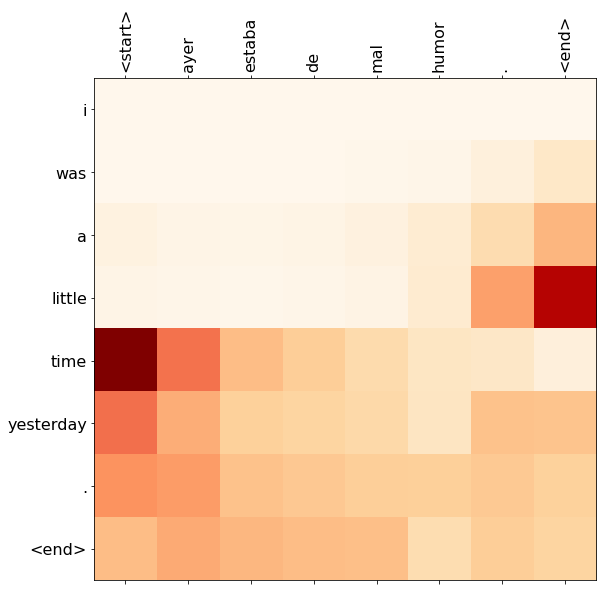

In [65]:
translate("ayer estaba de mal humor.")

[1, 4, 364, 8, 267, 13, 18, 2]
Input: <start> que tipo de mujer es esta <end>
Predicted translation: i know where s the problem . <end>


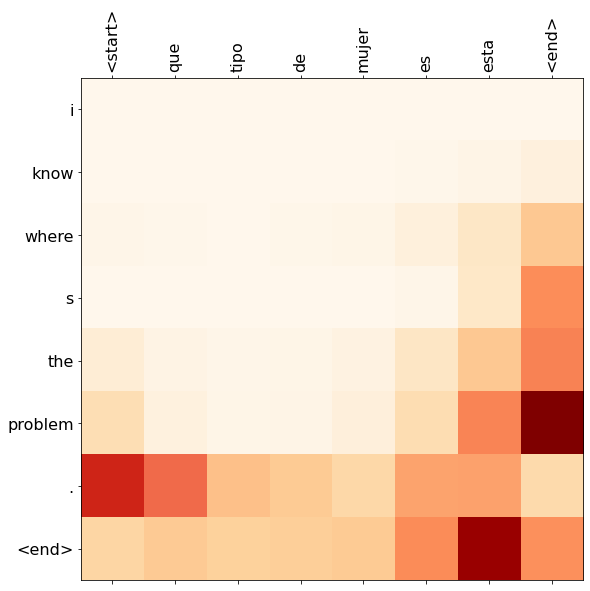

In [66]:
translate("que tipo de mujer es esta")

[1, 136, 13, 31, 205, 2]
Input: <start> cual es tu nombre <end>
Predicted translation: it s your name . <end>


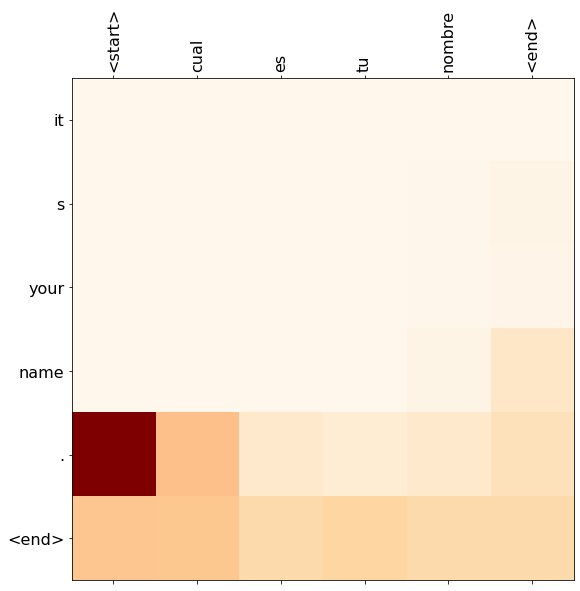

In [67]:
translate("cuál es tu nombre")